In [2]:
import xarray as xr, geopandas as gpd, matplotlib.pyplot as plt, regionmask, pandas as pd, numpy as np
import glob, re, os
from functools import reduce

from xclim.indices import uas_vas_to_sfcwind, cffwis_indices
from xclim.core.units import convert_units_to
from xclim.indicators.atmos import relative_humidity_from_dewpoint, vapor_pressure_deficit

import warnings; warnings.filterwarnings("ignore", category = FutureWarning)

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/IB_fire"

ERROR 1: PROJ: proj_create_from_database: Open of /rds/general/user/cb2714/home/miniforge3/envs/wwa/share/proj failed


# Download from ClimExp

In [55]:
# ! wget https://climexp.knmi.nl/data/era5_tmax_daily_eu_extended_-10-3.5E_36-44N_firstyear-lastyear_su.nc -O $fpath/tmax_era5_1950-2025.nc
# ! wget https://climexp.knmi.nl/data/era5_tp_daily_eu_extended_-10-3.5E_36-44N_-999-lastyear_su.nc -O $fpath/tp_era5_1950-2025.nc
# ! wget https://climexp.knmi.nl/data/era5_t2m_daily_eu_extended_-10-3.5E_36-44N_-999-lastyear_su.nc -O $fpath/t2m_era5_1950-2025.nc

--2025-08-27 17:34:23--  https://climexp.knmi.nl/data/era5_t2m_daily_eu_extended_-10-3.5E_36-44N_-999-lastyear_su.nc
Resolving climexp.knmi.nl (climexp.knmi.nl)... 2a0c:5bc0:4c:ff::9126:ce95, 145.38.206.149
Connecting to climexp.knmi.nl (climexp.knmi.nl)|2a0c:5bc0:4c:ff::9126:ce95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149473219 (143M) [application/x-netcdf]
Saving to: ‘/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/IB_fire/t2m_era5_1950-2025.nc’

/rds/general/user/c 100%[===================>] 142.55M   269MB/s    in 0.5s    

2025-08-27 17:34:23 (269 MB/s) - ‘/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/IB_fire/t2m_era5_1950-2025.nc’ saved [149473219/149473219]



# Tidy up Copernicus data

In [ ]:
! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-3/2025-08-27/83413fca775c34d235d491904d3ef952.nc -O $fpath/chunks/dasmax_era5_2025.nc

In [45]:
! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-3/2025-08-27/d440ba68983c62ac19d3f8a85885aa18.grib -O $fpath/chunks/uv10-hourly_era5_2025.grib

--2025-08-27 10:46:22--  https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-3/2025-08-27/d440ba68983c62ac19d3f8a85885aa18.grib
Resolving object-store.os-api.cci2.ecmwf.int (object-store.os-api.cci2.ecmwf.int)... 2a0c:5bc0:4c:ff::889c:8803, 136.156.136.3
connected. to object-store.os-api.cci2.ecmwf.int (object-store.os-api.cci2.ecmwf.int)|2a0c:5bc0:4c:ff::889c:8803|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 41880552 (40M) [application/x-grib]
Saving to: ‘/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/IB_fire/chunks/uv10-hourly_era5_2025.grib’

/rds/general/user/c 100%[===================>]  39.94M  12.8MB/s    in 3.1s    

2025-08-27 10:46:25 (12.8 MB/s) - ‘/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/IB_fire/chunks/uv10-hourly_era5_2025.grib’ saved [41880552/41880552]



In [ ]:
uv = xr.open_dataset("data/6508f23967e7b0f498cae88fef1bd95e.nc").reset_coords(drop = True)
sfcWind, windDir = uas_vas_to_sfcwind(uas = uv.u10, vas = uv.v10)
sfcWindmax = sfcWind.resample(valid_time = "D").max().rename("sfcWindmax")
sfcWindmax.rename(valid_time = "time", latitude = "lat", longitude = "lon").to_netcdf("data/sfcWindmax_era5_250601-250817.nc")

In [ ]:
tp = xr.open_dataset("data/b407000e7807cf903ff96738f2eb2721.nc").reset_coords(drop = True)
tp.rename(valid_time = "time", latitude = "lat", longitude = "lon").to_netcdf("data/tpmax_era5_250601-250816.nc")

In [27]:
d2m = xr.open_dataset("data/cf84353383fdc2250bf2f1bb95c2b43a.nc").reset_coords(drop = True).d2m
d2m.rename("dasmax", valid_time = "time", latitude = "lat", longitude = "lon").to_netcdf("data/dasmax_era5_250601-250816.nc")

In [28]:
t2m = xr.open_dataset("data/f85b73816f3d6f07b998348c1400a6c2.nc").reset_coords(drop = True).t2m
t2m.rename(valid_time = "time", latitude = "lat", longitude = "lon").to_netcdf("data/tasmax_era5_250601-250816.nc")

In [31]:
tp = xr.open_dataset("data/6a64c0acad88587385f51c960bc85dda.nc").reset_coords(drop = True).tp
tp.rename(valid_time = "time", latitude = "lat", longitude = "lon").to_netcdf("data/tpsum_era5_250601-250817.nc")

In [34]:
tp = xr.open_dataset("data/678f9da359be0d1bfddd82c034942b9d.nc").reset_coords(drop = True).tp
tp.rename(valid_time = "time", latitude = "lat", longitude = "lon").to_netcdf("data/tphourlysum_era5_250601-250818.nc")

# Compile all data

## dasmax

In [ ]:
da_dkrz = xr.open_dataset(fpath+"/chunks/dasmax_era5_1950-2024.grb").d2m.reset_coords(drop = True)

da_2025 = xr.open_dataset(fpath+"/chunks/dasmax_era5_2025.nc").d2m.reset_coords(drop = True).rename(valid_time = "time")

da = xr.concat([convert_units_to(da, "degC") for da in [da_dkrz, da_2025]], "time").rename("dasmax", latitude = "lat", longitude = "lon")
da = da.assign_coords(time = da.time.dt.floor("D"))
da.to_netcdf(fpath+"/dasmax_era5_1950-2025.nc")

## sfcWindmax

In [2]:
uv_2025 = xr.open_dataset(fpath+"/chunks/uv10-hourly_era5_2025.grib")
wspd, wdir = uas_vas_to_sfcwind(uas = uv_2025.u10, vas = uv_2025.v10)
da_2025 = wspd.resample(time = "D").max().reset_coords(drop = True).rename("sfcWindmax", latitude = "lat", longitude = "lon")

da_2025.to_netcdf(fpath+"/chunks/sfcWindmax_era5_2025.nc")

In [ ]:
da_dkrz = xr.open_dataset(fpath+"/chunks/sfcWindmax_era5_1950-2024.grb").sfcWindmax.rename(latitude = "lat", longitude = "lon")
da_2025 = xr.open_dataset(fpath+"/chunks/sfcWindmax_era5_2025.nc").sfcWindmax

da = xr.concat([da_dkrz, da_2025], "time")
da.to_netcdf(fpath+"/sfcWindmax_era5_1950-2025.nc")

## tasmax

In [71]:
tasmax = xr.open_dataset(fpath+"/chunks/tasmax_era5_1950-2024.grb").mx2t
tasmax = convert_units_to(tasmax, "degC").rename("tmax").reset_coords(drop = True)
tasmax = tasmax.assign_coords(time = tasmax.time.dt.floor("D"))
tasmax.to_netcdf(fpath+"/tmax_era5-regridded_1950-2024.nc")

## tp

In [ ]:
tp = xr.open_dataset(fpath+"/chunks/tp_era5_1950-2024.grb").tp
tp = convert_units_to(tp, "mm").rename("tp").reset_coords(drop = True)
tp = tp.assign_coords(time = tp.time.dt.floor("D"))
tp.to_netcdf(fpath+"/tp_era5-regridded_1950-2024.nc")

# Derived variables
_NB. run on old cluster, new cluster keeps falling over_

## Hursmin

In [4]:
ds_hurs = xr.merge([xr.open_dataset(fpath+"/"+varnm+"_era5_1950-2025.nc").sel(time = slice(None, "2025-08-21")) for varnm in ["dasmax", "tmax"]])

In [ ]:
hursmin = relative_humidity_from_dewpoint(tas = ds.tmax, tdps = ds.dasmax)
hursmin.rename("hursmin").to_netcdf(fpath+"/hursmin_era5_1950-2025.nc")

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])
/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable has a non-conforming standard_name: Got `unknown`, expected `['dew_point_temperature']`
  check_valid(vardata, "standard_name", data["standard_name"])


## FWI

In [5]:
ds_fwi = xr.merge([xr.open_dataset(fpath+"/"+varnm+"_era5_1950-2025.nc").sel(time = slice(None, "2025-08-21")) for varnm in ["tmax","sfcWindmax","tp","hursmin"]])

In [9]:
fwi_out = cffwis_indices(tas = ds_fwi.tmax, pr = ds_fwi.tp, sfcWind = ds_fwi.sfcWindmax, hurs = ds_fwi.hursmin, lat = ds_fwi.lat)

/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:288: RuntimeWarning: invalid value encountered in _duff_moisture_code
  return super().__call__(*args, **kws)
/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:288: RuntimeWarning: invalid value encountered in _duff_moisture_code
  return super().__call__(*args, **kws)
/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/xclim/indices/fire/_cffwis.py:475: RuntimeWarning: invalid value encountered in divide
  (0.8 * dc * dmc) / (dmc + 0.4 * dc),  # *Eq.27a*#
/rds/general/user/cb2714/home/miniforge3/envs/wwa/lib/python3.13/site-packages/xclim/indices/fire/_cffwis.py:476: RuntimeWarning: invalid value encountered in divide
  dmc - (1.0 - 0.8 * dc / (dmc + 0.4 * dc)) * (0.92 + (0.0114 * dmc) ** 1.7),


In [16]:
fwi_vars = ["dc", "dmc", "ffmc", "isi", "bui", "fwi"]

for i in range(6):
    fwi_out[i].rename(fwi_vars[i]).to_netcdf(fpath+"/"+fwi_vars[i]+"_era5_1950-2025.nc")

In [26]:
dsr = (0.0272 * (fwi_out[-1] ** 1.77)).rename("dsr")

In [28]:
dsr.to_netcdf(fpath+"/dsr_era5_1950-2025.nc")

## VPD & HDWI

In [25]:
vpd = vapor_pressure_deficit(tas = ds_fwi.tmax, hurs = ds_fwi.hursmin)
vpd.rename("vpd").to_netcdf(fpath+"/vpd_era5_1950-2025.nc")

In [30]:
hdwi = vpd * ds_fwi.sfcWindmax

In [33]:
hdwi.rename("hdwi").to_netcdf(fpath+"/hdwi_era5_1950-2025.nc")

# Shapefile

In [16]:
from shapely.geometry import Point, Polygon

xn,xx,yn,yx = [-10,-4,40,44]

kg = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/koppen-geiger/kg_classifications.nc").kg_cat.sel(lon = slice(xn,xx), lat = slice(yn,yx))

sf_adm1 = gpd.read_file(fpath+"/sf_adm1").clip((-12,5,34,44))

In [19]:
iberia = regionmask.defined_regions.natural_earth_v5_1_2.countries_50.to_geodataframe().set_index("abbrevs").loc[["P","E"]].dissolve().explode(index_parts = False)
iberia = iberia.loc[iberia.geometry.area == iberia.geometry.area.max()]
iberia.set_crs("epsg:4326").to_file(fpath+"/sf_iberia")

sf_outer = iberia.clip((xn,yn,xx,yx))
sf_inner = gpd.GeoDataFrame({'geometry': gpd.GeoSeries([Polygon([(-6,39), (-3,39), (-3,42.5), (-6,42.5)])]), 'df':[1]})

<Axes: >

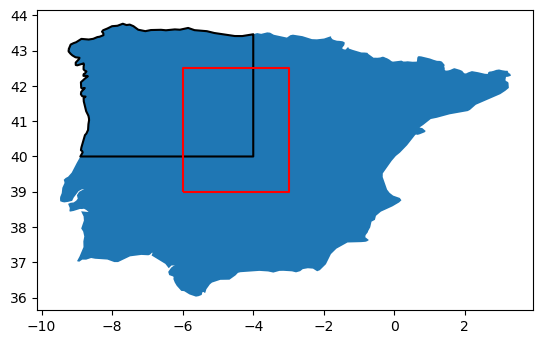

In [64]:
iberia.plot()
sf_outer.boundary.plot(ax = plt.gca(), color = "k")
sf_inner.boundary.plot(ax = plt.gca(), color = "red")

In [66]:
sf_l = sf_outer.overlay(sf_inner, how='difference')

In [70]:
sf_l.set_crs("epsg:4326").to_file(fpath+"/sf_nw-iberia")

<Axes: xlabel='lon', ylabel='lat'>

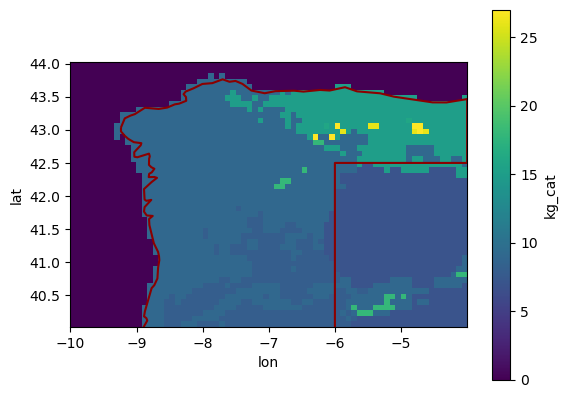

In [71]:
kg.plot()
sf_l.boundary.plot(ax = plt.gca(), color = "darkred")

In [ ]:
box_outer = gpd.GeoDataFrame({'geometry': gpd.GeoSeries([Polygon([(-10,40), (-4,40), (-4,44), (-10,44)])]), 'df':[1]})
sf_inner = gpd.GeoDataFrame({'geometry': gpd.GeoSeries([Polygon([(-6,39), (-3,39), (-3,42.5), (-6,42.5)])]), 'df':[1]})

sf_box = box_outer.overlay(sf_inner, how='difference')
sf_box.set_crs("epsg:4326").to_file(fpath+"/sf_box/")

<Axes: xlabel='lon', ylabel='lat'>

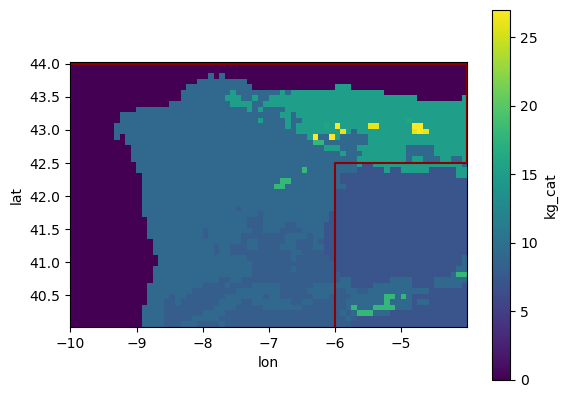

In [74]:
kg.plot()
sf_box.boundary.plot(ax = plt.gca(), color = "darkred")

In [ ]:
sf1 = gpd.read_file(fpath+"/sf_box")

## netcdf mask using ERA5 lsm

In [ ]:
# ! wget https://climexp.knmi.nl/ERA5/era5_000000_lsm_eu.nc -O data/era5-lsm.nc

# create a land-sea mask using ERA5 LSM and box
lsm = xr.open_dataset("data/era5-lsm.nc").squeeze(drop = True).lsm.rename(latitude = "lat", longitude = "lon")
sf_box = gpd.read_file(fpath+"/sf_box")

rm = xr.ones_like(lsm).where(lsm >= 0.5, drop = True)
rm = rm.where(regionmask.mask_geopandas(sf_box, rm) == 0, drop = True)

rm.to_netcdf(fpath+"/regionmask.nc")

# Daily time series

In [6]:
rm = xr.open_dataset(fpath+"/regionmask.nc").lsm

for fnm in sorted(glob.glob(fpath+"/*_era5_1950-2025.nc")):
    new_fnm = fpath+"/ts-daily/ts-"+fnm.split("/")[-1]
    if os.path.exists(new_fnm): continue
        
    da = xr.open_dataset(fnm).where(rm == 1, drop = True)
    ts = da.mean(["lat", "lon"])
    ts.to_netcdf(fpath+"/ts-daily/ts-"+fnm.split("/")[-1])

In [ ]:
# compile into dataframe for easier reference
df = reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'outer'), 
            [xr.open_dataset(fnm).to_dataframe() for fnm in sorted(glob.glob(fpath+"/ts-daily/*.nc"))]).dropna(axis = 0, how = "any")

df = df.rename(columns = {"__xarray_dataarray_variable___x" : "hursmin", "__xarray_dataarray_variable___y" : "vpd"})

df.to_csv(fpath+"/ts-daily_era5_allvars.csv")

In [ ]:
tmax = xr.open_dataset(fpath+"/tmax_era5_1950-2025.nc").tmax

spain = regionmask.defined_regions.natural_earth_v5_1_2.countries_50.to_geodataframe().set_index("abbrevs").loc[["E"]].dissolve().explode(index_parts = False)
spain = spain.loc[spain.geometry.area == spain.geometry.area.max()]
rm = regionmask.mask_geopandas(spain, tmax)
tmax = tmax.where(rm == 0, drop = True).mean(["lat", "lon"])

tx10x = tmax.rolling(time = 10).mean().resample(time = "YS").max()
tx10x.assign_coords(time = tx10x.time.dt.year).rename(time = "year").to_dataframe().to_csv("ts/tx10x-spain.csv")

## Annual time series

In [ ]:
da = xr.open_dataset("data/tp-jja_era5_1950-2025.nc").tp

rm = xr.open_dataset(fpath+"/regionmask.nc").lsm

tp_jja = da.where(rm == 1).mean(["lat", "lon"])
tp_jja.to_dataframe().to_csv("data/ts_tp-jja_era5_1950-2025.csv")

In [ ]:
da = xr.open_dataset("data/t2m-jja_era5_1950-2025.nc").t2m

rm = xr.open_dataset(fpath+"/regionmask.nc").lsm

tp_jja = da.where(rm == 1).mean(["lat", "lon"])
tp_jja.to_dataframe().to_csv("data/ts_t2m-jja_era5_1950-2025.csv")

In [ ]:
dsr = xr.open_dataset(fpath+"/ts-daily/ts-dsr_era5_1950-2025.nc")
dsrNx = dsr.rolling(time = 16).mean().resample(time = "AS").max()
dsrNx.assign_coords(time = dsrNx.time.dt.year).rename(time = "year").to_dataframe().to_csv("ts/dsr16x.csv")

# Prep data for pointwise trend analysis

## Compute annual indices

In [60]:
for varnm in ["tp", "tmax", "dsr", "t2m"]:
    da = xr.open_dataset(fpath+"/"+varnm+"_era5_1950-2025.nc")[varnm]
    da_jja = da.groupby("time.season")["JJA"].resample(time = "AS").mean()
    da_jja = da_jja.assign_coords(time = da_jja.time.dt.year).rename(time = "year")
    da_jja.to_netcdf("data/"+varnm+"-jja_era5_1950-2025.nc")

In [2]:
varnm = "dsr"
ndays = 10
da = xr.open_dataset(fpath+"/"+varnm+"_era5_1950-2025.nc")[varnm]
da_nday = da.rolling(time = ndays).mean().resample(time = "AS").max().rename(varnm+str(ndays)+"x")
da_nday = da_nday.assign_coords(time = da_nday.time.dt.year).rename(time = "year")
da_nday.to_netcdf("data/"+varnm+str(ndays)+"x_era5_1950-2025.nc")

## Flatten data for full pointwise analysis

In [3]:
for varnm in ["t2m-jja", "tmax-jja", "tp-jja", "dsr5x", "dsr10x"][-1:]:

    # load pre-computed index
    da = xr.open_dataset("data/"+varnm+"_era5_1950-2025.nc")[varnm.split("-")[0]]
    rm = regionmask.defined_regions.natural_earth_v5_1_2.land_50.mask(da)
    da = da.where(rm == 0)

    # save the map for easier reconstruction later
    da.mean("year").to_netcdf("pointwise/map-tmplt_"+varnm+"_era5.nc")

    # flatten & convert to data.frame
    df = da.stack(xy = ["lat", "lon"]).dropna(dim = "xy", how = "all").to_pandas()

    df.to_csv("pointwise/"+varnm+"-flattened_era5.csv")

In [ ]:
varnm = "tp-jja"
da = xr.open_dataset("data/"+varnm+"_era5_1950-2025.nc")[varnm.split("-")[0]]
da = np.log(da); varnm = "logtp-jja"

rm = regionmask.defined_regions.natural_earth_v5_1_2.land_50.mask(da)
da = da.where(rm == 0)

# save the map for easier reconstruction later
da.mean("year").to_netcdf("pointwise/map-tmplt_"+varnm+"_era5.nc")

# flatten & convert to data.frame
df = da.stack(xy = ["lat", "lon"]).dropna(dim = "xy", how = "all").to_pandas()

df.to_csv("pointwise/"+varnm+"-flattened_era5.csv")

# tx10x for whole of Spain & Portugal

In [40]:
varnm = "tmax"
txnm = {"tmax" : "tx", "t2m" : "tg"}[varnm]
ndays = 10

sf = gpd.read_file(fpath+"/sf_iberia")
da = xr.open_dataset(fpath+"/"+varnm+"_era5_1950-2025.nc")[varnm]

rm = regionmask.mask_geopandas(sf, da)

ts = da.where(rm == 0, drop = True).mean(["lat", "lon"])
tx10x = ts.rolling(time = ndays).mean().resample(time = "AS").max()
tx10x.assign_coords(time = tx10x.time.dt.year).rename(varnm, time = "year").to_dataframe().to_csv("ts/"+txnm+str(ndays)+"x-iberia.csv")